"""
## **Created on Monday June 29 2020**

# @author: Ali Farooq, Felix Facklam, Dieter Hoogestraat
"""

Tensor flow 2.2.0, Python 3.6

Generative Adversarial Networks (GANs) are one of the most interesting idea in Deep learning nowadays. Two models are trained simultaneously in an adversarial process. A generator model learns to create images that look real, while a discriminator learns to discriminate between real and generated fake images. Both models are trained until generator generates real images and the discriminator is unable to discriminate them as fake.

Covid 19 is the most discussed topic nowadays. As the whole world is effected by this disease. This is the best time to utilize Deep laerning algorithm to make good predictions. The main problem behind unsuccessful or bad predictions are datasets. Most of the time we don't have big dataset to train the model for good predictions. Therefore we have same problem with Covid 19 Lungs CT-Scan dataset. We have only 316 patients dataset to create a prediction algorithm. This code is using Generative GANs to generate artificial data. Below you can find the code which generates fake lungs Ct-Scans.

Import Tensorflow and other Libraries.

Mount your google drive to access CTCOVID data.

Load and prepare dataset for training.



In [ ]:
import tensorflow as tf

print(tf.__version__)

# To generate GIFs
!pip install imageio

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

from google.colab import drive
drive.mount('/content/drive')

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

folder = '/content/drive/My Drive/CTScans/CT_COVID'
#folder = "../input/regression_sample"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

imgs = []
for of in onlyfiles:
  #print('working on: ', of)
  img = load_img(folder + "/" + of, target_size=(112,168))
  #print(img.size)
  img1= img.convert('L')
  img1 = np.expand_dims(img1, axis = -1)
  imgs.append(img1)
  


imgs = np.asarray(imgs).astype('float32')

2.2.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working with 316 images
Image examples: 


In [ ]:
train_images = (imgs - 127.5)/127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 100

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Create Models both generator and discriminator using keras library.

Generator model get random noise and start with the dense layer as the deconvolution neural network. It has 3 convolution layers with activation function LeakyRelu and Tanh at the final layer. The input random noise shape is 100 but it get shape into 112,168. 

In [ ]:
def make_generator_model():  
    model = tf.keras.Sequential()
    model.add(layers.Dense(28*42*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((28,42, 256)))
    assert model.output_shape == (None, 28,42, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28,42, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56,84, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 112,168 ,1)
    
    return model

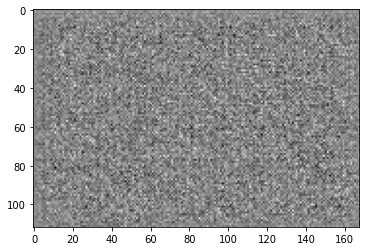

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Discriminator model get real images from CT_COVID dataset and fake images from generator as an input. It will train to distinguish real and fake images. The model consist of 3 convolution layers with leakyRelu activation function and final layer is flattern. The model is trainied to produce positive result on real images and negative on fake images.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[112,168, 1]))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00013496]], shape=(1, 1), dtype=float32)


Define loss and optimizer functions for both generator and discriminator model. the discriminator loss is calculated on both real and fake images and sum up together to optimize parameters. On the other hand generator parameters optimize only on the fake images loss. The loss function for both models is binary cross entropy and optimizer is adam with 0004 learning rate.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Save checkpoints of your both models for long running tasks.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define the training epochs and number of images which are generated ny generator. In this case 16 images.

In [ ]:
EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16


# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images and fakes images. The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    if (epoch + 1) % 1000 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                                epoch + 1,
                                seed)

    # Save the model every 1000 epochs
    if (epoch + 1) % 1000 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Generate and save images all together as gif and individual.

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(12,12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Start training the models.

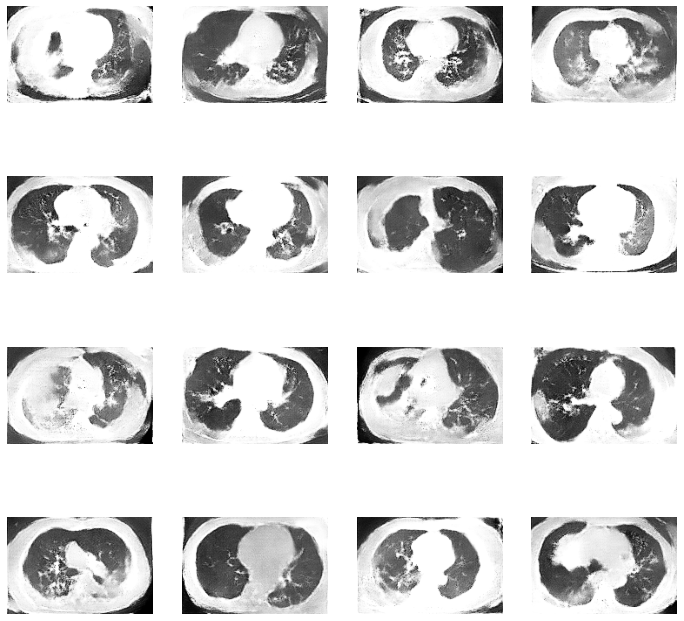

Training time was 7860.591433763504 sec


In [ ]:
xtime = time.time()
print(xtime)
train(train_dataset, EPOCHS)
print ('Training time was {} sec'.format(time.time()-xtime))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

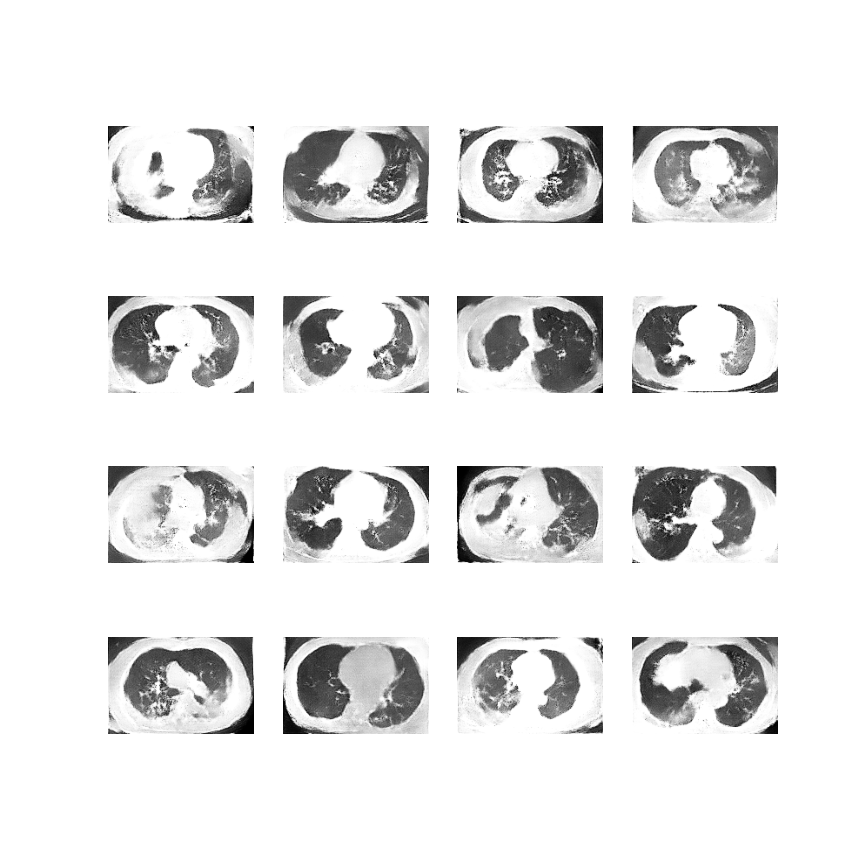

In [ ]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

aödlkjfdsaf\ņ
 16
öaljföasjfödsjfödsjföfsf


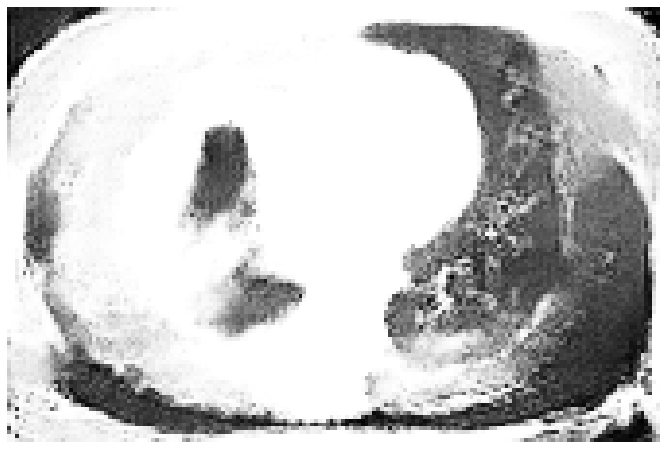

öaljföasjfödsjfödsjföfsf


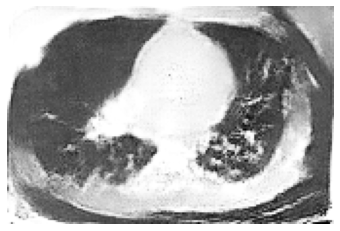

öaljföasjfödsjfödsjföfsf


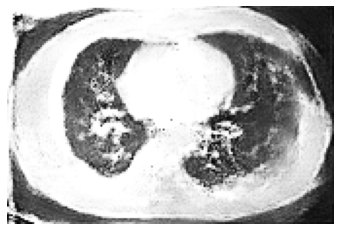

öaljföasjfödsjfödsjföfsf


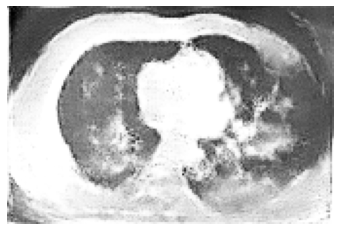

öaljföasjfödsjfödsjföfsf


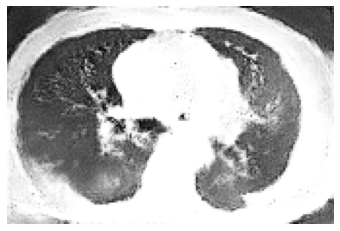

öaljföasjfödsjfödsjföfsf


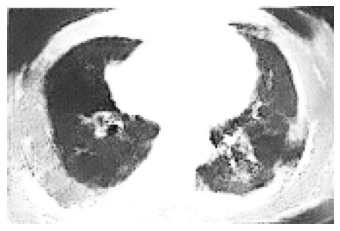

öaljföasjfödsjfödsjföfsf


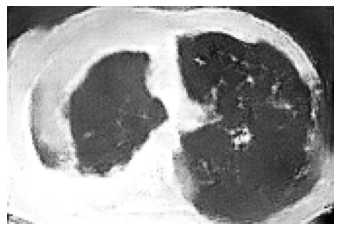

öaljföasjfödsjfödsjföfsf


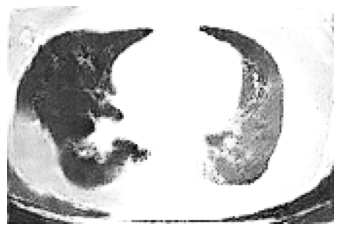

öaljföasjfödsjfödsjföfsf


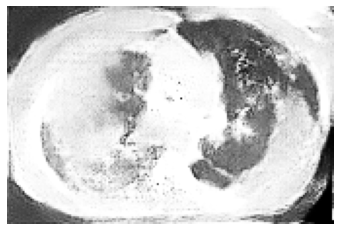

öaljföasjfödsjfödsjföfsf


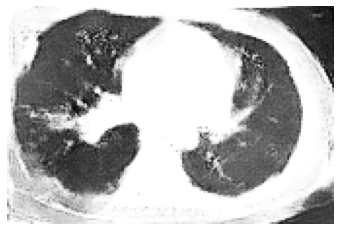

öaljföasjfödsjfödsjföfsf


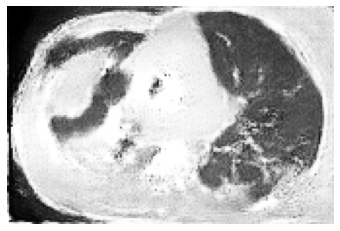

öaljföasjfödsjfödsjföfsf


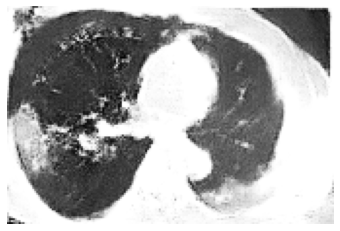

öaljföasjfödsjfödsjföfsf


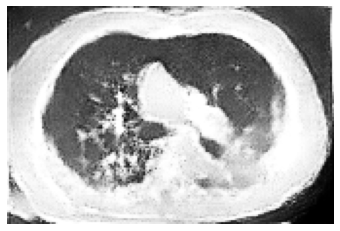

öaljföasjfödsjfödsjföfsf


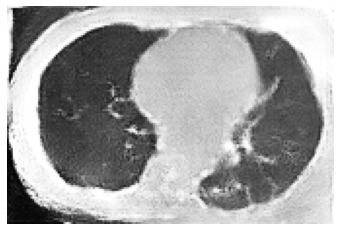

öaljföasjfödsjfödsjföfsf


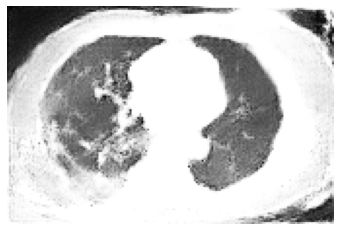

öaljföasjfödsjfödsjföfsf


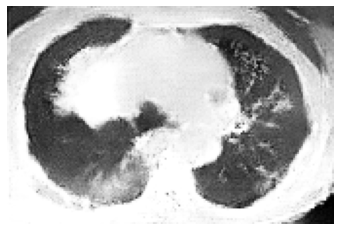

<Figure size 432x288 with 0 Axes>

In [ ]:
seeds = tf.random.normal([5, noise_dim])


def generate_and_save_images2(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,8))
  print('aödlkjfdsaf\ņ\n',predictions.shape[0])
  for i in range(predictions.shape[0]):
      #plt.subplot(4, 4, i+1)
      print ('öaljföasjfödsjfödsjföfsf')
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      plt.show()

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

generate_and_save_images2(generator,
                           1000,
                           seed)

Download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm training_checkpoints/*
!ls